In [1]:
import itertools
import json
import os
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics

from utils import data_utils, shape_utils

import importlib
importlib.reload(data_utils)

RUN_FOLDER = "../results/1mo_new_data//"
SEQ_MODELS = ['AVG_SEQ',"PERSISTENT",'RNN_BASE','RNN']

In [2]:
kcm_deeptte_results = data_utils.extract_deeptte_results("Seattle", RUN_FOLDER, "kcm/")
atb_deeptte_results = data_utils.extract_deeptte_results("Trondheim", RUN_FOLDER, "atb/")
kcm_deeptte_result_df = kcm_deeptte_results[['Model','City','Fold','MAPE','RMSE','MAE']].copy()
atb_deeptte_result_df = atb_deeptte_results[['Model','City','Fold','MAPE','RMSE','MAE']].copy()

In [3]:
kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)

In [4]:
performances_df = pd.concat([kcm_result_df, atb_result_df, kcm_deeptte_result_df, atb_deeptte_result_df], axis=0).sort_values(['Model','City','Fold'])
# performances_df = pd.concat([kcm_fresult_df, atb_result_df], axis=0).sort_values(['Model','City','Fold'])
model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

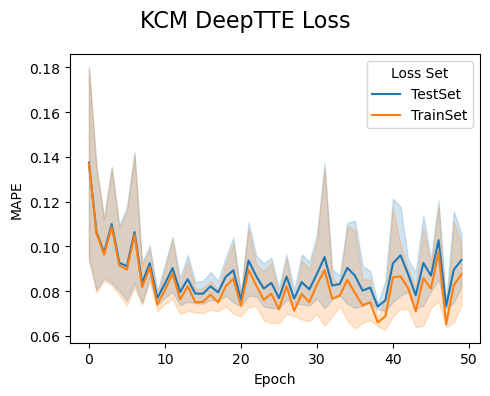

In [5]:
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(kcm_deeptte_results, x="Epoch", y="MAPE", hue="Loss Set", ax=axes)
fig.suptitle('KCM DeepTTE Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_deeptte_kcm.png", dpi=1800, bbox_inches='tight')

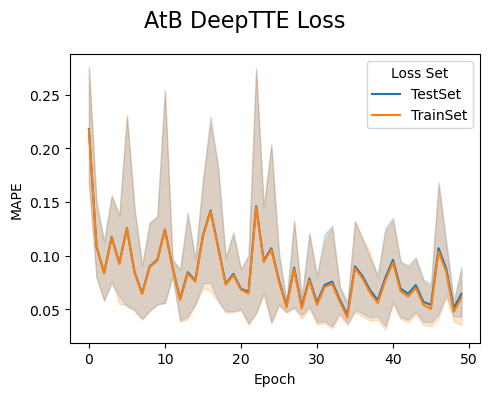

In [6]:
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(atb_deeptte_results, x="Epoch", y="MAPE", hue="Loss Set", ax=axes)
fig.suptitle('AtB DeepTTE Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_deeptte_atb.png", dpi=1800, bbox_inches='tight')

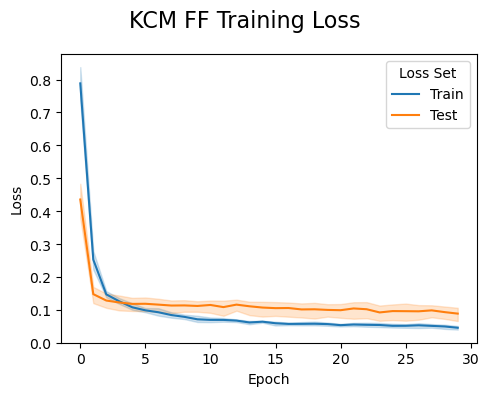

In [7]:
plot_data = model_curves_df[model_curves_df['City']=="Seattle"]
plot_data = plot_data[plot_data['Model']=='FF']
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('KCM FF Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_ff_kcm.png", dpi=1800, bbox_inches='tight')

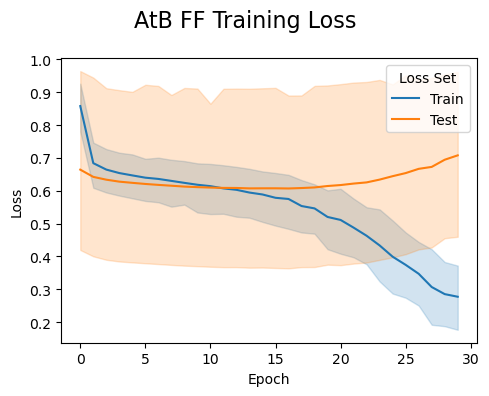

In [8]:
plot_data = model_curves_df[model_curves_df['City']=="Trondheim"]
plot_data = plot_data[plot_data['Model']=='FF']
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('AtB FF Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_ff_atb.png", dpi=1800, bbox_inches='tight')

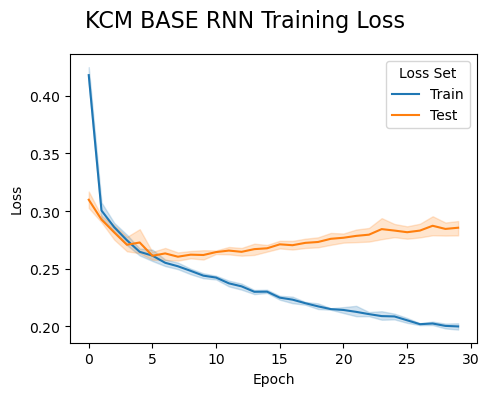

In [9]:
plot_data = model_curves_df[model_curves_df['City']=="Seattle"]
plot_data = plot_data[plot_data['Model']=='RNN_BASE']
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('KCM BASE RNN Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_rnn_base_kcm.png", dpi=1800, bbox_inches='tight')

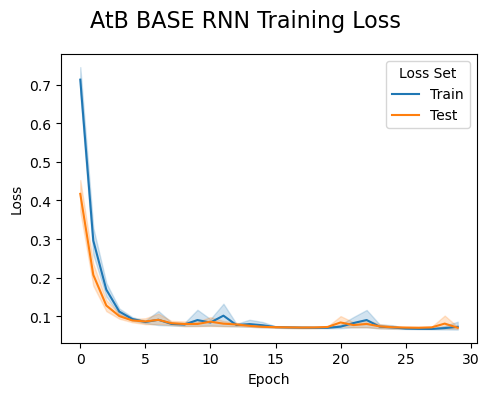

In [10]:
plot_data = model_curves_df[model_curves_df['City']=="Trondheim"]
plot_data = plot_data[plot_data['Model']=='RNN_BASE']
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('AtB BASE RNN Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_rnn_base_atb.png", dpi=1800, bbox_inches='tight')

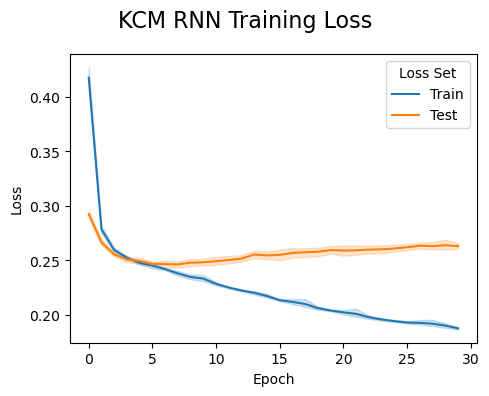

In [11]:
plot_data = model_curves_df[model_curves_df['City']=="Seattle"]
plot_data = plot_data[plot_data['Model']=='RNN']
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('KCM RNN Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_rnn_kcm.png", dpi=1800, bbox_inches='tight')

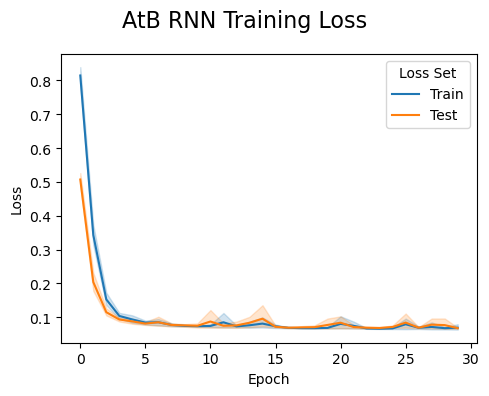

In [12]:
plot_data = model_curves_df[model_curves_df['City']=="Trondheim"]
plot_data = plot_data[plot_data['Model']=='RNN']
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('AtB RNN Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_rnn_atb.png", dpi=1800, bbox_inches='tight')

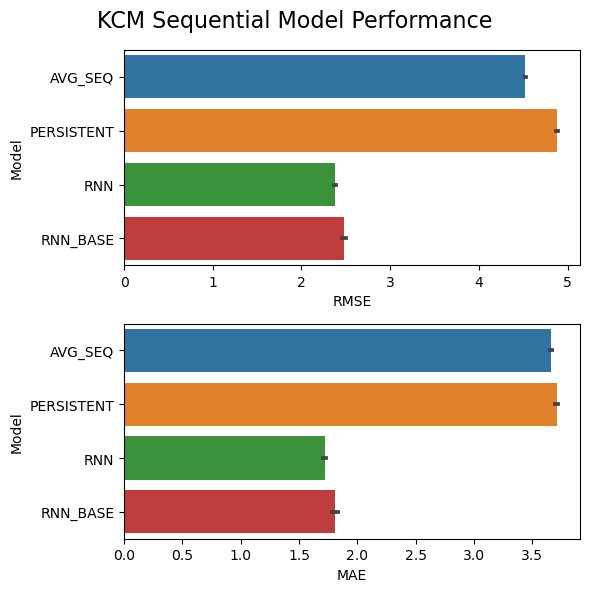

In [13]:
plot_data = performances_df[performances_df['City']=="Seattle"]
plot_data = plot_data[plot_data['Model'].isin(SEQ_MODELS)]
fig, axes = plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[1])
fig.suptitle('KCM Sequential Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_seq_kcm.png", dpi=1800, bbox_inches='tight')

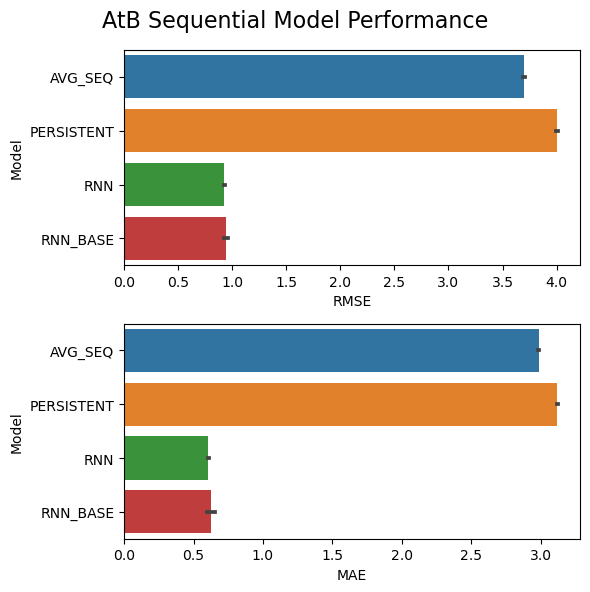

In [14]:
plot_data = performances_df[performances_df['City']=="Trondheim"]
plot_data = plot_data[plot_data['Model'].isin(SEQ_MODELS)]
fig, axes = plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[1])
fig.suptitle('AtB Sequential Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_seq_atb.png", dpi=1800, bbox_inches='tight')

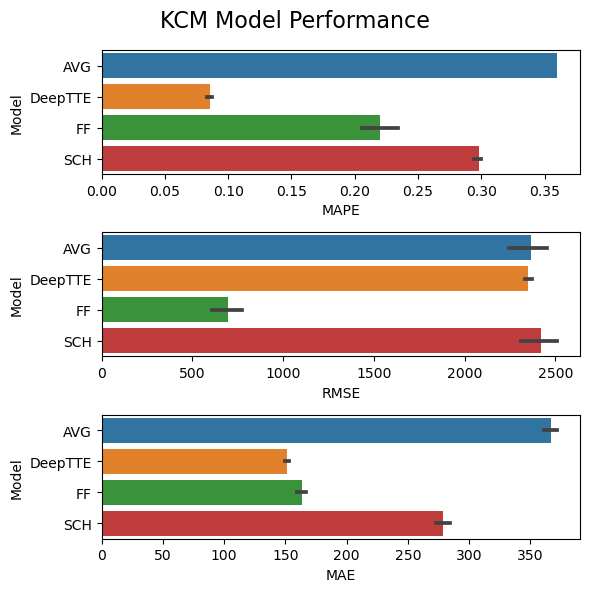

In [15]:
plot_data = performances_df[performances_df['City']=="Seattle"]
plot_data = plot_data[~plot_data['Model'].isin(SEQ_MODELS)]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.png", dpi=1800, bbox_inches='tight')

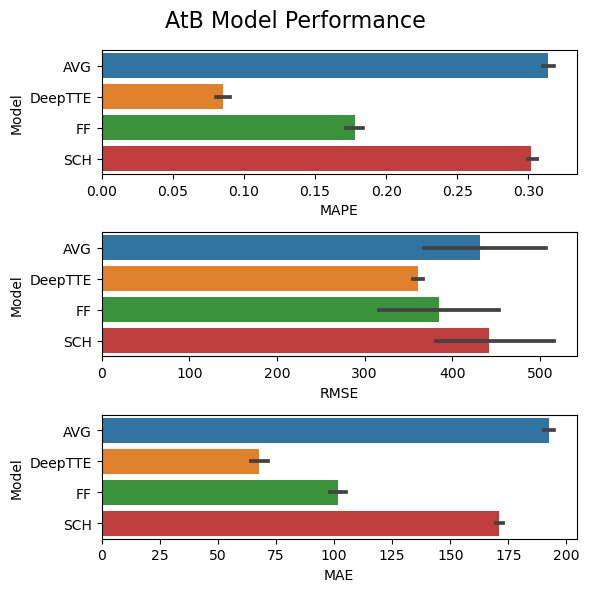

In [16]:
plot_data = performances_df[performances_df['City']=="Trondheim"]
plot_data = plot_data[~plot_data['Model'].isin(SEQ_MODELS)]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.png", dpi=1800, bbox_inches='tight')